# Выпускной проект. Прогнозирование разрыва абонентом договора

###### Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

###### Описание услуг

###### Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic)

###### Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

###### Цель работы
Основной задачей является построение модели, которая позволит с высокой точностью предсказывать вероятность оттока клиентов, чтобы компания могла принять меры по удержанию клиентов и оптимизации своей работы.

Ключевая метрика для оценки модели — ROC-AUC, а задача проекта заключается в достижении максимальной производительности модели при корректной обработке и анализе данных.

## Описание данных


Данные состоят из нескольких файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv:
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.


Файл personal_new.csv:
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл internet_new.csv:
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл phone_new.csv:
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

###### Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

## План работы

Работа выполняется в следующей последовательности:

- Шаг 1. Загрузка данных и первичный осмотр

## Шаг 1. Загрузка данных и первичный осмотр.

In [19]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import joblib
import xgboost as xgb
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

import shap
from phik import phik_matrix

In [20]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

RANDOM_STATE = 141024

In [21]:
# Функция для загрузки данных
def load_data(file_name):
    try:
        return pd.read_csv(rf'C:\datasets\praktikum\12\{file_name}')
    except FileNotFoundError:
        return pd.read_csv(f'/datasets/{file_name}')

# Загрузка данных
contract = load_data('contract_new.csv')
personal = load_data('personal_new.csv')
internet = load_data('internet_new.csv')
phone = load_data('phone_new.csv')

In [22]:
# Просмотр первых строк каждого файла
print("Информация о договоре")
display(contract.head())
print("\n")
display(contract.info())
print("\n")

print("Персональные данные клиента")
display(personal.head())
print("\n")
display(personal.info())
print("\n")

print("Информация об интернет-услугах")
display(internet.head())
print("\n")
display(internet.info())
print("\n")

print("Информация об услугах телефонии")
display(phone.head())
print("\n")
display(phone.info())

Информация о договоре


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None



Персональные данные клиента


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None



Информация об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None



Информация об услугах телефонии


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

### Вывод по шагу 1

Мы импортировали библиотеки и нструменты, загрузили и осмотрели данные. Вот что можно заметить:

- число строк в таблицах отличается, возможно имеются пропуски, либо не все абоненты пользуются телефонной связью или интернетом;
- наменование столбцов выполнено не в соответствии со "змеиным" регистром;
- стобец TotalCharges в информация о договоре заполнен числами, но имеет тип "object".

## Шаг 2. Исследовательский анализ (предварительный) и предобработка данных

### Шаг 2.1. Предобработка данных

In [28]:
# Приведение к змеиному регистру
contract.rename(columns={
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges'
}, inplace=True)

personal.rename(columns={
    'customerID': 'customer_id',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents'
}, inplace=True)

internet.rename(columns={
    'customerID': 'customer_id',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies'
}, inplace=True)

phone.rename(columns={
    'customerID': 'customer_id',
    'MultipleLines': 'multiple_lines'
}, inplace=True)

# Проверка
display(contract.columns)
display(personal.columns)
display(internet.columns)
display(phone.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Index(['customer_id', 'multiple_lines'], dtype='object')

In [29]:
# Проверим везде ли в столбце 'total_charges' записаны только цифры и точка?
invalid_rows = contract[contract['total_charges'].apply(lambda x: bool(re.search(r'[^0-9.]', str(x))))]
display(invalid_rows)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Видим, что несколько строк имеют пустые значения в столбце 'total_charges'. Видно, что причина - договор заключен в день выгрузки и абоненты пока не оплачивали счета. Поэтому эти значения заполним нулями

In [31]:
# Изменение типа данных в столбце 'total_charges'
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

In [33]:
# Заполнение пропусков нулями
contract['total_charges'] = contract['total_charges'].fillna(0)

In [34]:
# Проверка
display(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


None

Также необходимо обработать значения 'senior_citizen' (клиент - пенсионер), заменить 0 на 'No', 1 - на 'Yes'

In [36]:
# Заменяем значения в столбце senior_citizen
personal['senior_citizen'] = personal['senior_citizen'].replace({0: 'No', 1: 'Yes'})
# Проверяем изменения
display(personal['senior_citizen'].unique())

array(['No', 'Yes'], dtype=object)

In [37]:
# Преобразуем даты в формат datetime
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d', errors='coerce')

In [38]:
# Проверка
display(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


None

In [39]:
# Проверка на пропуски и дубликаты
print("Информация о договоре")
display(contract.isnull().sum())
display(contract.duplicated().sum())
print("\n")

print("Персональные данные клиента")
display(personal.isnull().sum())
display(personal.duplicated().sum())
print("\n")

print("Информация об интернет-услугах")
display(internet.isnull().sum())
display(internet.duplicated().sum())
print("\n")

print("Информация об услугах телефонии")
display(phone.isnull().sum())
display(phone.duplicated().sum())

Информация о договоре


customer_id             0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
dtype: int64

0



Персональные данные клиента


customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

0



Информация об интернет-услугах


customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

0



Информация об услугах телефонии


customer_id       0
multiple_lines    0
dtype: int64

0

У нас отсутствуют пропуски и дубликаты. Пропуски в столбце 'end_date' нам известны, т.к. появились после изменения типов данных. Т.к. есть дополнительный столбец, который указывает на событие "разрыв договора", то эти пропуски не повлияют на дальнейшую работу

### Шаг 2.2. Исследовательский анализ (предварительный)

#### Шаг 2.2.1. Информация о договоре

In [43]:
# Посмотрим статистику
display(contract.describe())

,begin_date,end_date,monthly_charges,total_charges
count,7043,1101,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2018-03-12 18:21:15.204359680,64.761692,2115.312885
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,0.000000
25%,2015-06-01 00:00:00,2017-05-01 00:00:00,35.500000,436.750000
50%,2017-09-01 00:00:00,2018-06-01 00:00:00,70.350000,1343.350000
75%,2019-04-01 00:00:00,2019-04-01 00:00:00,89.850000,3236.690000
max,2020-02-01 00:00:00,2020-01-01 00:00:00,118.750000,9221.380000
std,NaN,NaN,30.090047,2112.742814


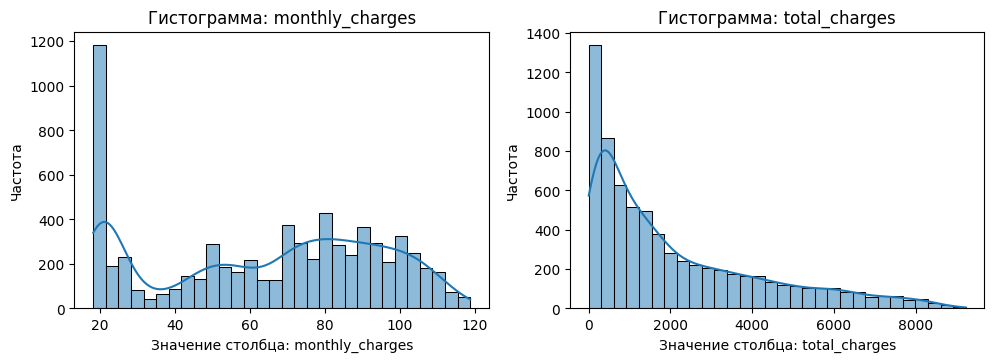

In [44]:
# Посмотрим на гистограммы числовых столбцов
numerical_columns = contract.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns):
    plt.subplot(3, 3, i + 1)  # Измените (3, 3)
    sns.histplot(contract[column], kde=True, bins=30)
    plt.title(f'Гистограмма: {column}')
    plt.xlabel(f'Значение столбца: {column}')
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

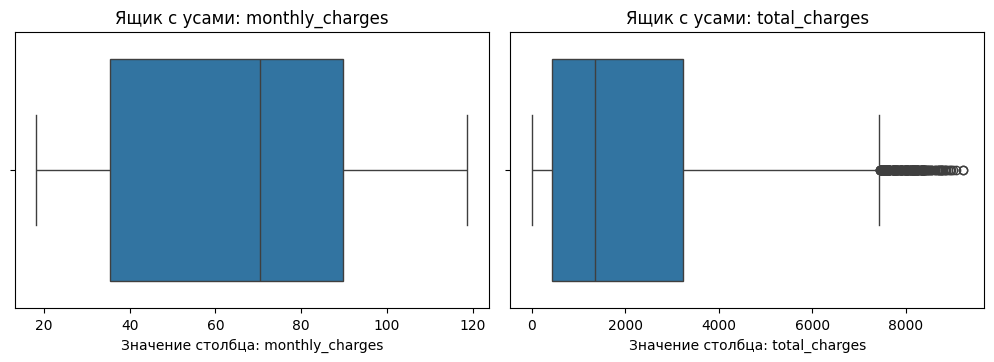

In [45]:
# Посмотрим на ящики с усами
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=contract[column])
    plt.title(f'Ящик с усами: {column}')
    plt.xlabel(f'Значение столбца: {column}')

plt.tight_layout()
plt.show()

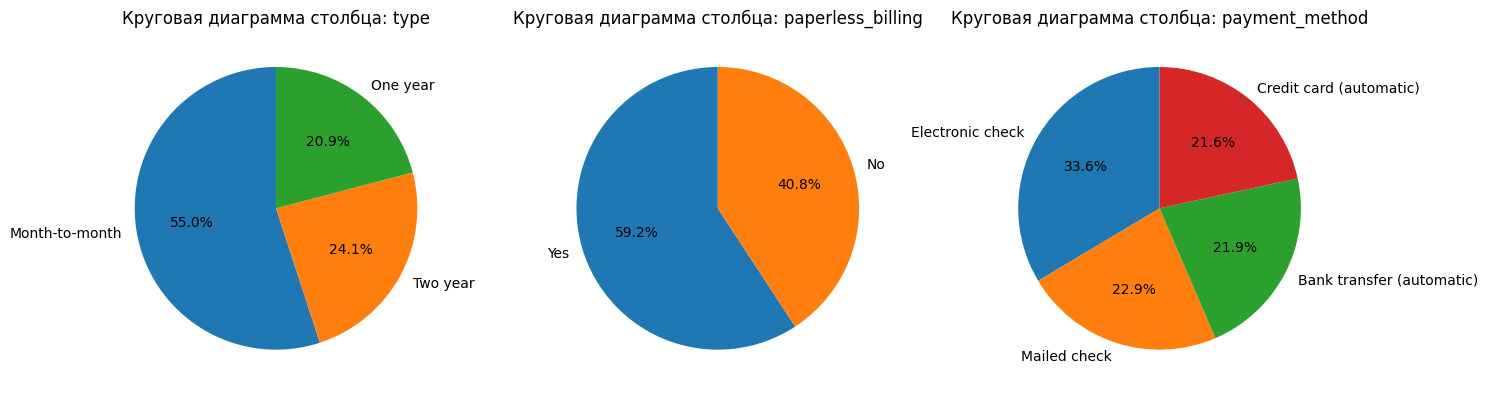

In [46]:
# Посмотрим на круговые диаграммы категориальных столбцов
plt.figure(figsize=(15, 5))
columns = ['type', 'paperless_billing', 'payment_method']
for i, column in enumerate(columns):
    plt.subplot(1, 3, i + 1)  # Создаем подграфики
    contract[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(f'Круговая диаграмма столбца: {column}')
    plt.ylabel('')
plt.tight_layout()
plt.show()

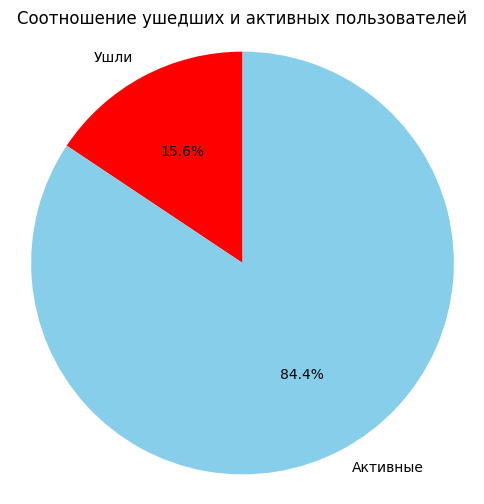

In [47]:
# Нарисуем диаграмму ушедших клиентов
proportions = contract['end_date'].count() / contract.shape[0]
labels = ['Ушли', 'Активные']
values = [proportions, 1 - proportions]  # Доля активных пользователей

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'skyblue'])
plt.title('Соотношение ушедших и активных пользователей')
plt.axis('equal')
plt.show()

#### Шаг 2.2.2. Персональные данные клиента

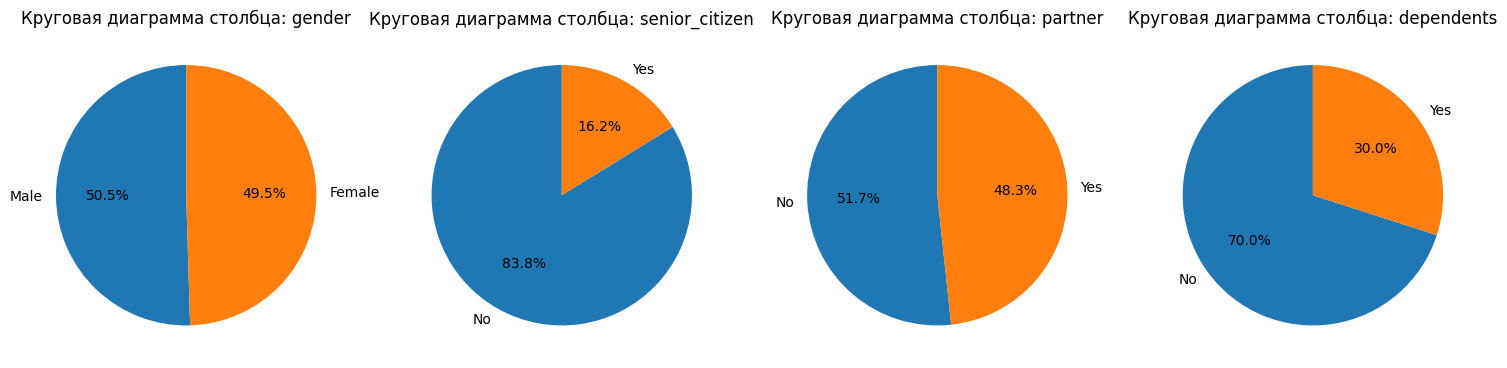

In [49]:
# Посмотрим на круговые диаграммы категориальных столбцов
plt.figure(figsize=(15, 5))
columns = ['gender', 'senior_citizen', 'partner', 'dependents']
for i, column in enumerate(columns):
    plt.subplot(1, 4, i + 1)  # Создаем подграфики
    personal[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(f'Круговая диаграмма столбца: {column}')
    plt.ylabel('')
plt.tight_layout()
plt.show()

#### Шаг 2.2.3. Информация об интернет-услугах

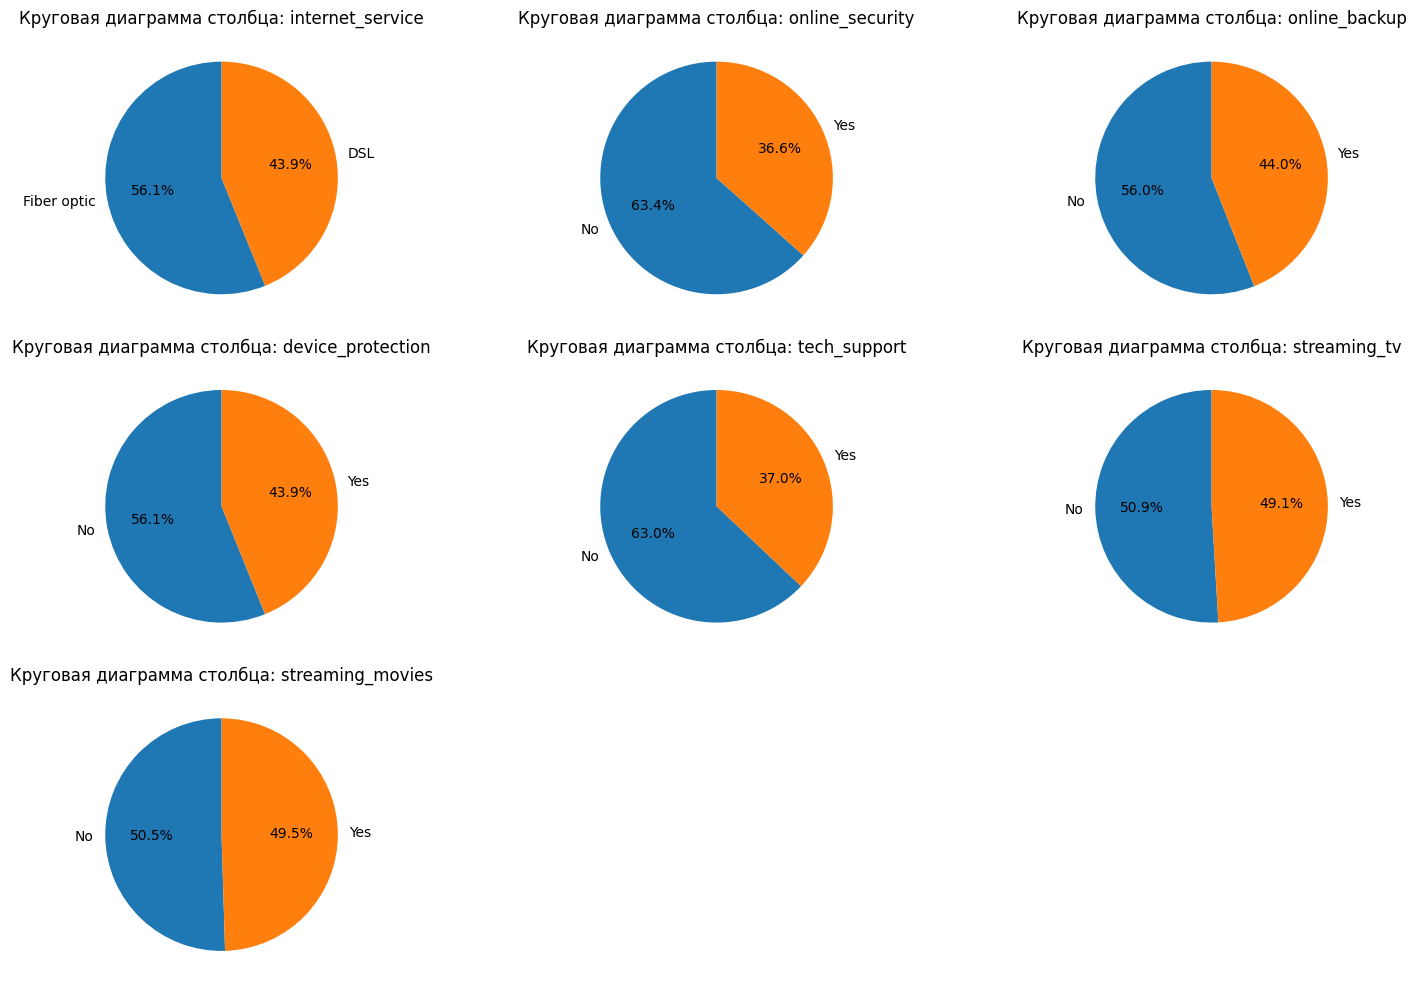

In [51]:
# Посмотрим на круговые диаграммы категориальных столбцов
plt.figure(figsize=(15, 10))
columns = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)  # Создаем подграфики
    internet[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(f'Круговая диаграмма столбца: {column}')
    plt.ylabel('')
plt.tight_layout()
plt.show()

#### Шаг 2.2.4. Информация об услугах телефонии

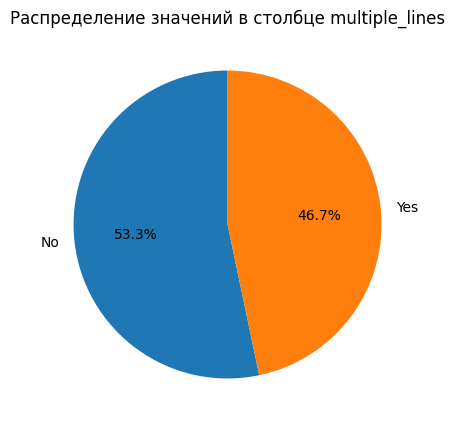

In [53]:
# Посмотрим на круговые диаграммы категориальных столбцов
value_counts = phone['multiple_lines'].value_counts()
# Построение круговой диаграммы
plt.figure(figsize=(5, 5))
plt.pie(phone['multiple_lines'].value_counts(), labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение значений в столбце multiple_lines')
plt.show()

### Вывод по шагу 2
- Мы выполнили предобработку: изменили тип данных отдельных столбцов, проверили на пропуски и дубликаты
- Мы провели первичный исследовательский анализ имеющихся данных
- Построили гистограмму и круговые диаграммы
- В таблице с договорами статистических аномалий нет
- Месячная оплата у большого количества клиентов - около 20. Есть также небольшие пики на 50 и 80
- Ушедших клиентов в выборке: 15,6%
- Пенсионеров: 16,2%, клиентов с детьми: 30%
- Более подробный исследовательский анализ будет проведен после объединения таблиц

## Шаг 3. Объединение данных

In [56]:
# Объединяем все 4 таблицы по столбцу 'customer_id'
data_full = contract.merge(personal, on='customer_id', how='outer') \
                      .merge(internet, on='customer_id', how='outer') \
                      .merge(phone, on='customer_id', how='outer')

# Просмотр первых строк объединенной таблицы
display(data_full.head())
display(data_full.info())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,0002-ORFBO,2019-05-01,NaT,One year,Yes,Mailed check,65.6,631.73,Female,No,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,2019-05-01,NaT,Month-to-month,No,Mailed check,59.9,539.10,Male,No,No,No,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,2019-09-01,NaT,Month-to-month,Yes,Electronic check,73.9,406.45,Male,No,No,No,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,2018-12-01,NaT,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,Yes,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,2019-09-01,NaT,Month-to-month,Yes,Mailed check,83.9,444.67,Female,Yes,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

None

### Вывод по шагу 3
- Объединили все таблицы в одну
- Т.к. количество строчек различалось, то образовались пропуски, которые будут обработаны в следующем шагу

## Шаг 4.Исследовательский анализ данных объединенного датафрейма

### Шаг 4.1. Предобработка в объединенном датафрейме

Мы знаем, что выгрузка данных осуществлена на дату 01.02.2020 г. Зная эту дату добавим новый столбец с длительностью пользования услугами и столбец с разрывов договора. Закодируем вручную: 1 - договор разорван, 0 - договор не разорван. Перед этим мы уже изменили тип данных для дат. Создадим переменную с текущей датой

In [64]:
# Текущая дата для расчетов — 1 февраля 2020 года
current_date = pd.to_datetime('2020-02-01')

# Добавляем новый столбец 'client_left', который показывает, разорвал ли абонент договор
data_full['client_left'] = data_full['end_date'].notna().astype(int)

# Рассчитываем длительность договора:
# Если в 'end_date' стоит  NaT, берем разницу с текущей датой; если есть дата окончания, берем разницу между 'end_date' и 'begin_date'
data_full['end_date'].fillna(current_date, inplace=True)
data_full['contract_duration'] = (data_full['end_date'] - data_full['begin_date']).dt.days

# Проверим результат
display(data_full[['begin_date', 'end_date', 'contract_duration', 'client_left']].head(20))

,begin_date,end_date,contract_duration,client_left
0,2019-05-01,2020-02-01,276,0
1,2019-05-01,2020-02-01,276,0
2,2019-09-01,2020-02-01,153,0
3,2018-12-01,2020-02-01,427,0
4,2019-09-01,2020-02-01,153,0
5,2019-05-01,2020-02-01,276,0
6,2014-03-01,2020-02-01,2163,0
7,2014-11-01,2020-02-01,1918,0
8,2019-07-01,2020-02-01,215,0
9,2014-09-01,2020-02-01,1979,0


После объединения у нас имеются пропуски в объединенном датафрейме, т.к. данные о интернет услугах и телефонии включали меньшее количество строк. Пропуски можно заполнить значениями 'No'. Логично предположить, если нет информации о предоставленной услуге, то услугу не предоставляют. Исключением является пропуски в столбце internet_service (тип подключения). Посмотрим какие типы подключения имеются.

In [66]:
display(data_full['internet_service'].unique())

array(['DSL', 'Fiber optic', nan], dtype=object)

И так у нас два типа подлючения:

- DSL (более простая и старая технология, такое подключение имеет меньшую скорость);
- Fiber optic (оптическое волокно, более современный тип подключения с высокими скоростями).

Посмотрим на цены услуг в зависимости от типа подключения и посмотрим на ту группу, в которой тип подключения не указан.

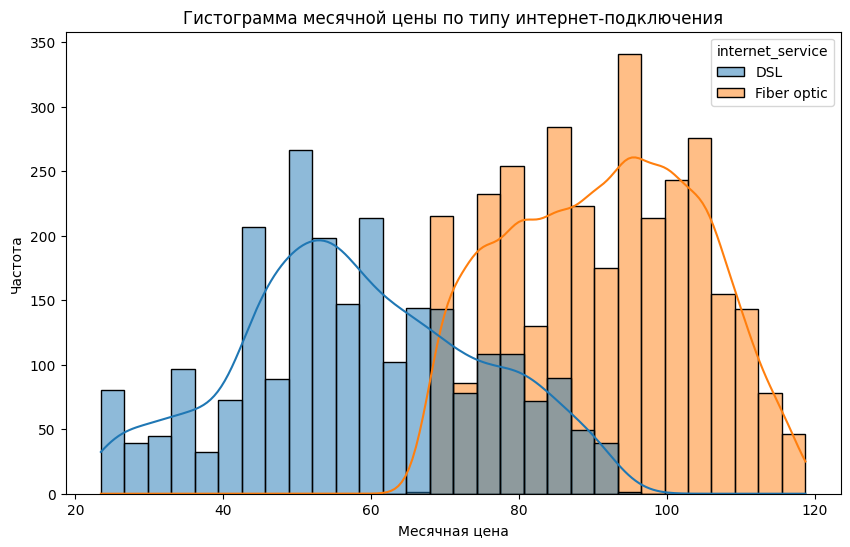

In [68]:
# Строим гистограмму с разными типами подключения
plt.figure(figsize=(10, 6))
sns.histplot(data=data_full, x='monthly_charges', hue='internet_service', kde=True, bins=30)
plt.title('Гистограмма месячной цены по типу интернет-подключения')
plt.xlabel('Месячная цена')
plt.ylabel('Частота')
plt.show()

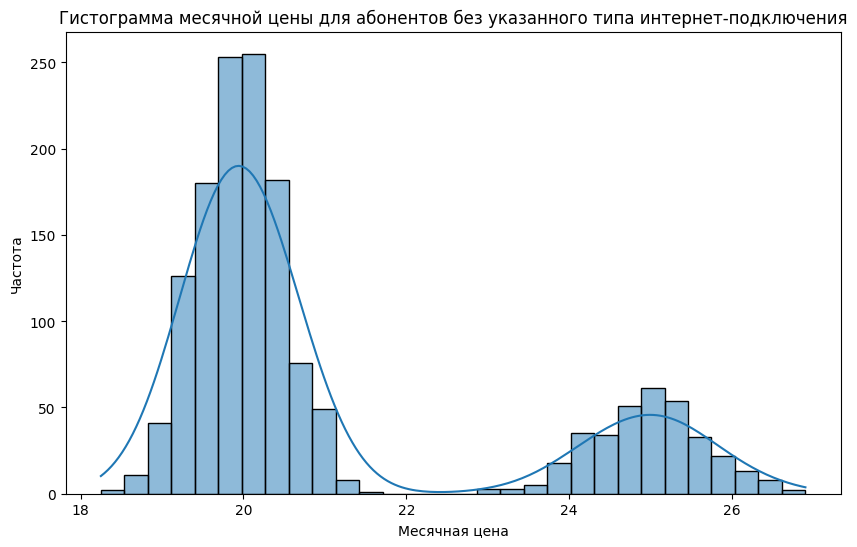

In [69]:
# Строим гистограмму для абонентов, у которых не указан тип подключения
missing_service = data_full[data_full['internet_service'].isnull()]
plt.figure(figsize=(10, 6))
sns.histplot(data=missing_service, x='monthly_charges', kde=True, bins=30)
plt.title('Гистограмма месячной цены для абонентов без указанного типа интернет-подключения')
plt.xlabel('Месячная цена')
plt.ylabel('Частота')
plt.show()

Мы видим, что там, где не указан тип поключения месячная цена очень низкая, менее 30. В то время как для оптического волокна цена начинается от 60. Соответственно пропущенные значения необходимо заполнить значением "DSL". По другим услугам: если нет информации о предоставлении услуги, будем считать услугу непредоставленной. Обработаем все пропуски в объединенном датафрейме

In [71]:
# Заполнение пропусков в столбце internet_service значением 'DSL'
data_full['internet_service'] = data_full['internet_service'].fillna('DSL')

# Заполнение пропусков значением 'No'
columns_fill = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
data_full[columns_fill] = data_full[columns_fill].fillna('No')

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Согласен, можно заполнить пропуски таким образом!
  
</div>

In [73]:
# Проверка типов данных
display(data_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

None

### Шаг 4.2. Исследовательский анализ данных объединенного датафрейма

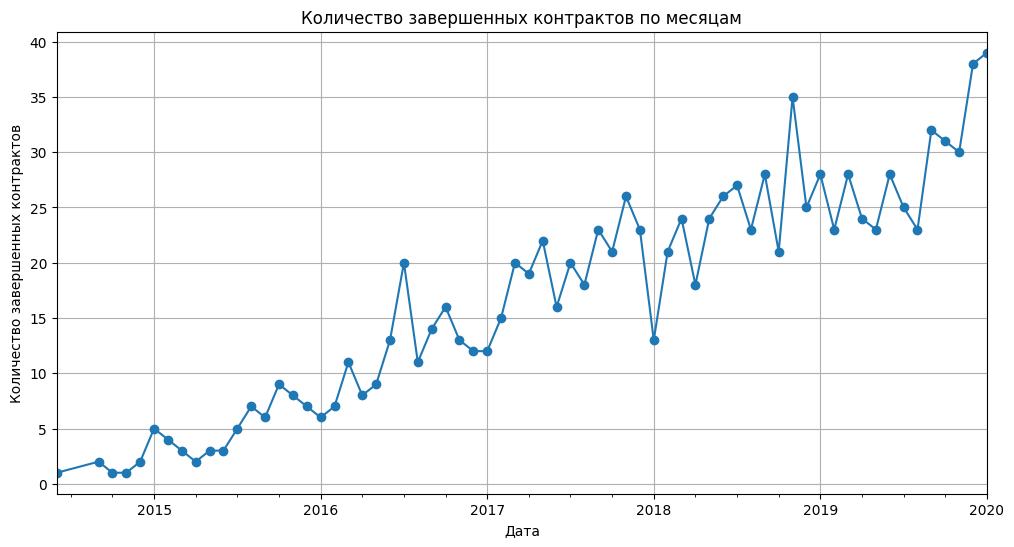

count    66.000000
mean     16.681818
std      10.137757
min       1.000000
25%       7.250000
50%      18.000000
75%      24.000000
max      39.000000
Name: count, dtype: float64

In [77]:
# Посмотрим на временной ряд разорванных договоров
monthly_end_counts = data_full[data_full['client_left'] == 1]['end_date'].dt.to_period('M').value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_end_counts.plot(kind='line', marker='o')
plt.title('Количество завершенных контрактов по месяцам')
plt.xlabel('Дата')
plt.ylabel('Количество завершенных контрактов')
plt.grid()
plt.show()

# Получение статистики
display(monthly_end_counts.describe())

Сезонности и периодичности не наблюдается. Но тренд восходящий, что не очень хорошо для компании

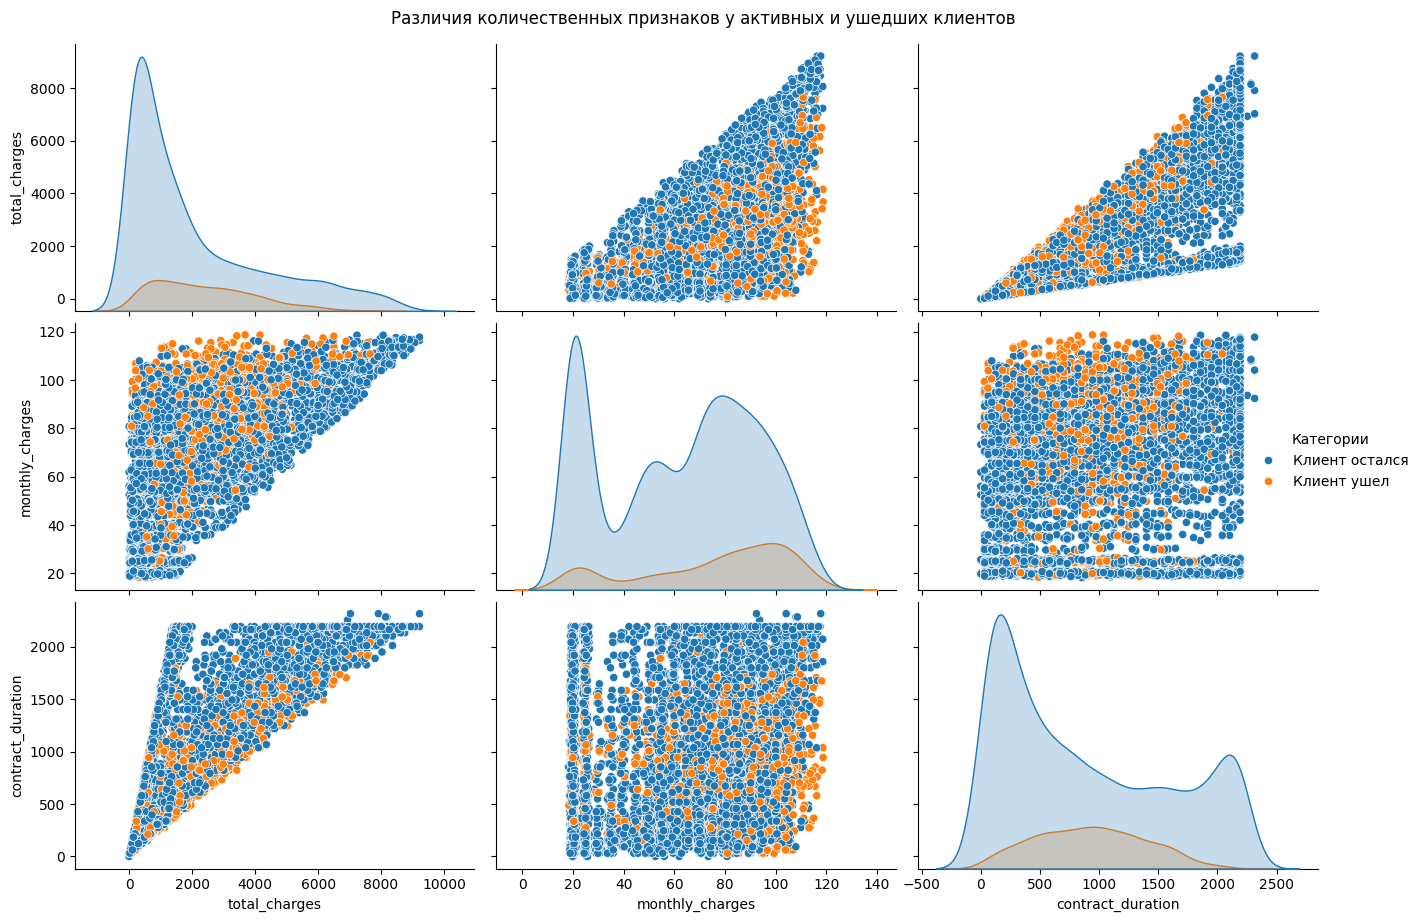

In [79]:
# Посмотрим на различия количественных признаков у активных и ушедших клиентов
pairplot = sns.pairplot(data_full, vars=['total_charges', 'monthly_charges', 'contract_duration'], hue='client_left', height=3, aspect=1.5)
plt.suptitle('Различия количественных признаков у активных и ушедших клиентов', y=1.02)
new_labels = ['Клиент остался', 'Клиент ушел']
for t, l in zip(pairplot._legend.texts, new_labels):
    t.set_text(l)
pairplot._legend.set_title('Категории')
plt.show()

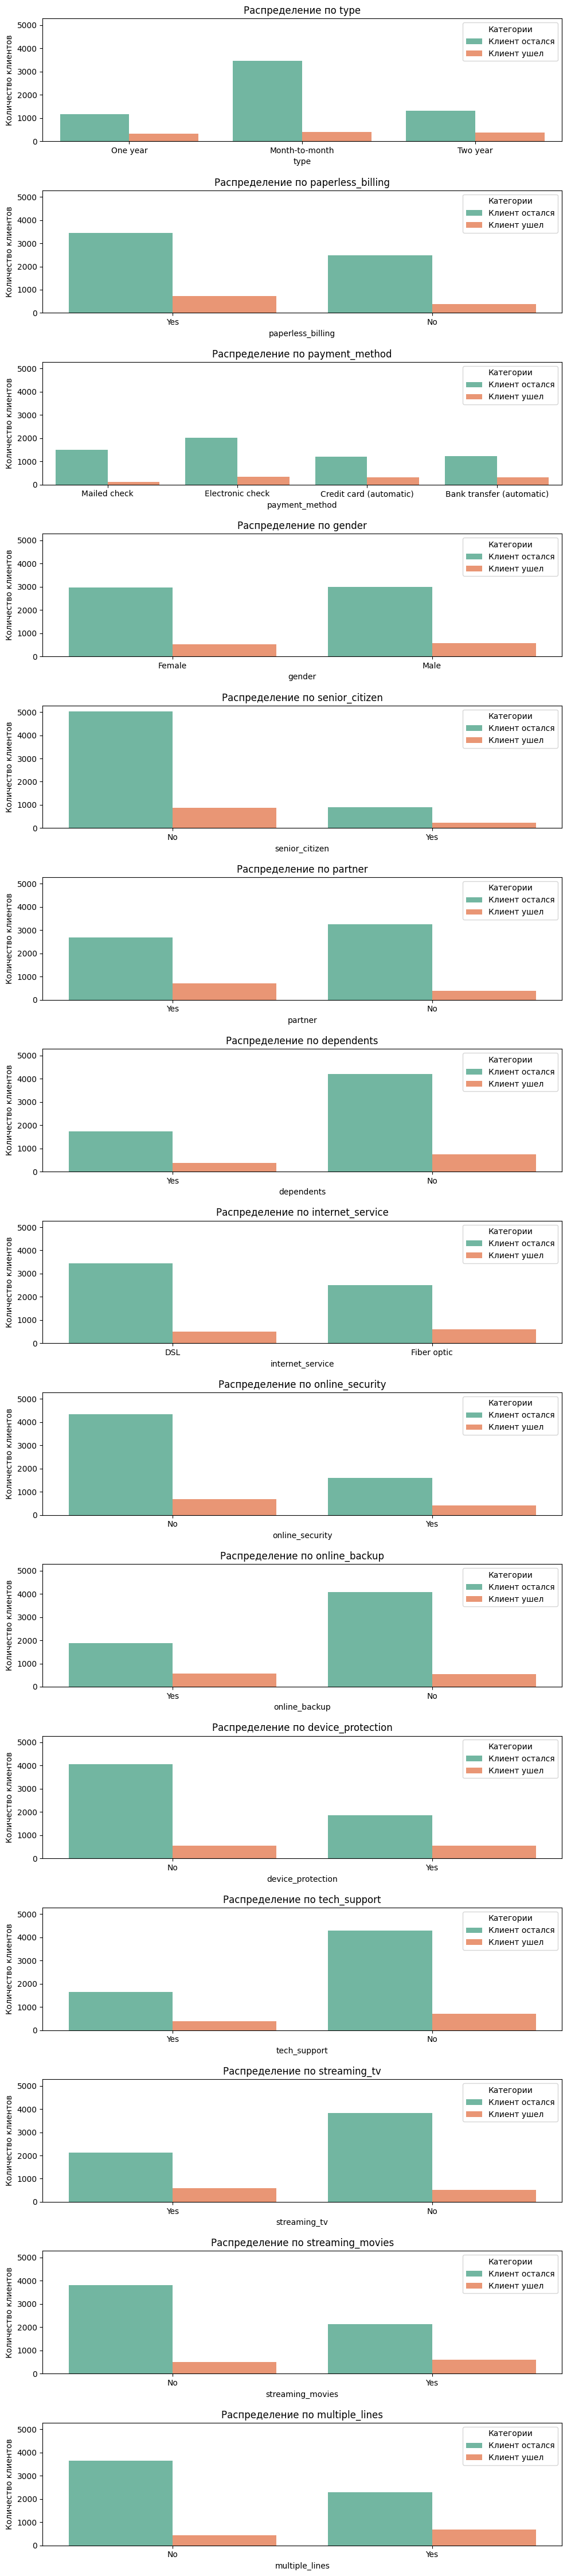

In [80]:
# Посмотрим на различия категориальных признаков у активных и ушедших клиентов
categorical_vars = [
    'type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
    'partner', 'dependents', 'internet_service', 'online_security', 
    'online_backup', 'device_protection', 'tech_support', 
    'streaming_tv', 'streaming_movies', 'multiple_lines'
]

fig, axes = plt.subplots(nrows=len(categorical_vars), ncols=1, figsize=(10, len(categorical_vars) * 3), sharey=True)
new_labels = ['Клиент остался', 'Клиент ушел']
for ax, var in zip(axes, categorical_vars):
    sns.countplot(data=data_full, x=var, hue='client_left', ax=ax, palette='Set2')
    ax.set_title(f'Распределение по {var}')
    ax.set_ylabel('Количество клиентов')
    
    handles, _ = ax.get_legend_handles_labels()
    for handle, label in zip(handles, new_labels):
        handle.set_label(label)
    
    ax.legend(title='Категории', loc='upper right')
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

### Шаг 4.3. Проверка на коллинеарность

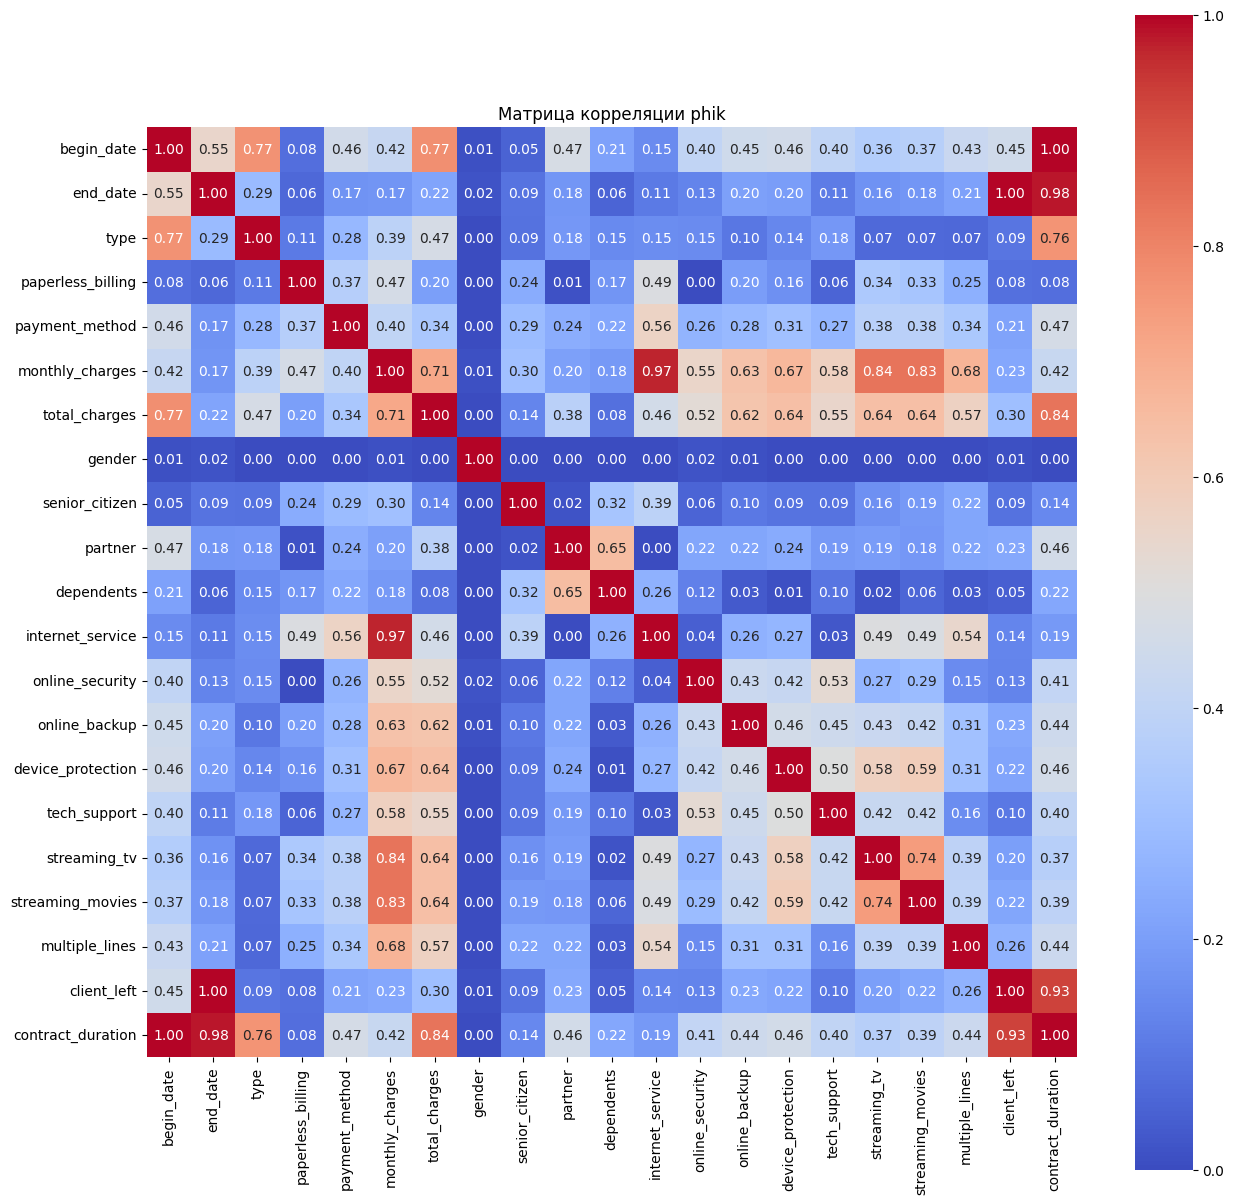

In [82]:
# Указываем интервальные столбцы 
interval_cols = ['monthly_charges', 'total_charges', 'duration_days']

# Вычисляем матрицу корреляции phik с указанием интервальных столбцов
correlation_matrix = (data_full.drop(columns=['customer_id'], errors='ignore')).phik_matrix(interval_cols=interval_cols)

# Создаем тепловую карту
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Матрица корреляции phik')
plt.show()

- Имеется практически полная коллинеарность между месячной стоимостью и типом подключения
- Также достаточно высокая коллинеарность имеется между месячной стоимостью и стримингом фильмов/ТВ
- Для исключения коллинеарности мы добавим кластеры столбца 'monthly_chargens', по тем пикам, которые заметили раньше (20, 50, 80)
- Столбец с месячной стоимостью удалим

### Вывод по шагу 4
- Провели полный исследовательский и корреляционный анализ 
- У ушедших клиентов больше общая стоимость оказанных услуг, но это может объясняться длительностью, т.к. договор разрывается через какое-то время после заключения
- Месячная стоимость также выше
- Разрывают договор чаще (по соотношению) абоненты с оплатой раз в год и раз в два года
- Еще заметно более невыгодное распределение для абонентов с несколькими телефонными линиями
- Имеется практически полная коллинеарность между месячной стоимостью и типом подключения
- Также достаточно высокая коллинеарность имеется между целевой переменной и длительностью договора

## Шаг 5. Подготовка данных

Удалим данные с датами, т.к. мы добавили столбец с продолжительностью столбца, а также 'customer_id'

In [91]:
# Удаляем столбец 'end_date', 'begin_date', 'total_charges'
data_full = data_full.drop(columns=['end_date', 'begin_date', 'customer_id'])
# Проверяем изменения
display(data_full.head())

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,contract_duration
0,One year,Yes,Mailed check,65.6,631.73,Female,No,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No,0,276
1,Month-to-month,No,Mailed check,59.9,539.10,Male,No,No,No,DSL,No,No,No,No,No,Yes,Yes,0,276
2,Month-to-month,Yes,Electronic check,73.9,406.45,Male,No,No,No,Fiber optic,No,No,Yes,No,No,No,No,0,153
3,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,Yes,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,0,427
4,Month-to-month,Yes,Mailed check,83.9,444.67,Female,Yes,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No,0,153


In [94]:
# Разделение на признаки (X) и целевой признак (y), замените 'target_column' на ваш целевой признак
X = data_full.drop(columns=['client_left'])
y = data_full['client_left']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [99]:
# Кодируем признаки
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Обучаем кодировщик на объединенных данных
colums_to_encode = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents',
                    'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
                    'streaming_movies', 'multiple_lines']
X_train_enc = encoder.fit_transform(X_train[colums_to_encode])

# Получаем имена новых столбцов
encoded_columns = encoder.get_feature_names_out(colums_to_encode)

# Создаем DataFrame для закодированных данных
encoded_df = pd.DataFrame(X_train_enc, columns=encoded_columns, index=X_train.index)

# Проверяем совпадают ли индексы
print(X_train.index.equals(encoded_df.index))  # должно быть True

# Объединяем закодированные данные с исходным DataFrame
X_train = pd.concat([X_train, encoded_df], axis=1)

# Удаляем закодированные столбцы
columns_to_drop = colums_to_encode
X_train = X_train.drop(columns=columns_to_drop)

# Проверяем результат
display(X_train.head())

True


,monthly_charges,total_charges,contract_duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_Yes,partner_Yes,dependents_Yes,internet_service_Fiber optic,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
6708,89.80,1998.95,638,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5178,19.90,355.21,518,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2490,45.55,45.55,31,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3127,105.05,4042.32,1126,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3006,20.55,1517.21,2102,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# Кодируем данные
X_test_enc = encoder.transform(X_test[colums_to_encode])

# Получаем имена новых столбцов
encoded_columns = encoder.get_feature_names_out(colums_to_encode)

# Создаем DataFrame для закодированных данных
encoded_df = pd.DataFrame(X_test_enc, columns=encoded_columns, index=X_test.index)

# Проверяем совпадают ли индексы
print(X_test.index.equals(encoded_df.index))  # должно быть True

X_test = pd.concat([X_test, encoded_df], axis=1)
X_test = X_test.drop(columns=columns_to_drop)
display(X_test.head())

True


,monthly_charges,total_charges,contract_duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_Yes,partner_Yes,dependents_Yes,internet_service_Fiber optic,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
5542,24.95,149.70,184,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1869,86.10,3776.35,1310,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3202,105.30,737.10,215,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2885,68.75,3643.75,1614,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2845,96.20,700.34,215,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


### Вывод по шагу 5
- Подготовили данные к обучению
- Разделили на целевую переменную и признаки
- Обработали нечисловые значения OneHotEncoder
- На тестовую выборку оставили 25%

## Шаг 6. Обучение моделей машинного обучения

### Логистическая регрессия

In [108]:
# Указываем числовые признаки
numerical_features = ['total_charges', 'monthly_charges', 'contract_duration']

# Укажите остальные признаки, которые не требуют кодирования (они уже закодированы)
categorical_features = ['type_One year', 'type_Two year', 'paperless_billing_Yes', 'payment_method_Credit card (automatic)',
                        'payment_method_Electronic check', 'payment_method_Mailed check', 'gender_Male', 'senior_citizen_Yes', 'partner_Yes',
                        'dependents_Yes', 'internet_service_Fiber optic', 'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes', 
                        'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes', 'multiple_lines_Yes']

# Создаем ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Применяем StandardScaler к числовым признакам
        ('cat', 'passthrough', categorical_features)  # Пропускаем все остальные признаки
    ])

# Определяем модель и пайплайн
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])

# Определяем параметры для перебора
param_grid_log_reg = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l1', 'l2', 'elasticnet'],  # Если использовать solver='saga'
    'log_reg__l1_ratio': [0.0, 0.5, 1.0],  # Для elasticnet
    'log_reg__solver': ['liblinear', 'saga', 'lbfgs'],  # Выбор метода оптимизации
    'log_reg__class_weight': [None, 'balanced'],  # Веса классов
    'log_reg__max_iter': [100, 200, 300]
}

# Создаем объект GridSearchCV
grid_search_log_reg = GridSearchCV(estimator=pipeline, param_grid=param_grid_log_reg, cv=5, scoring='roc_auc', n_jobs=-1)

# Обучаем модель
%time grid_search_log_reg.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search_log_reg.best_params_)

# Оценка модели с использованием кросс-валидации
cross_val_roc_auc_log_reg = grid_search_log_reg.best_score_
print("ROC AUC на кросс-валидации:", cross_val_roc_auc_log_reg)

CPU times: total: 4.16 s
Wall time: 19.5 s
Лучшие параметры: {'log_reg__C': 100, 'log_reg__class_weight': None, 'log_reg__l1_ratio': 0.0, 'log_reg__max_iter': 100, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}
ROC AUC на кросс-валидации: 0.7679268565530286


### Decision Tree

In [112]:
# Определяем модель
decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Определяем параметры для перебора
param_grid_dt = {
    'decision_tree__max_depth': [None, 5, 10, 15, 20],  # Максимальная глубина дерева
    'decision_tree__min_samples_split': [2, 5, 10],     # Минимальное количество образцов для разделения узла
    'decision_tree__min_samples_leaf': [1, 2, 4],       # Минимальное количество образцов на листовом узле
    'decision_tree__max_features': [None, 'sqrt', 'log2'],  # Количество признаков для поиска наилучшего разделения
}

# Создаем пайплайн
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('decision_tree', decision_tree)
])

# Создаем объект GridSearchCV
grid_search_dt = GridSearchCV(estimator=pipeline, param_grid=param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)

# Обучаем модель
%time grid_search_dt.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search_dt.best_params_)

# Выводим результаты
cross_val_roc_auc_dt = grid_search_dt.best_score_
print("ROC AUC на кросс-валидации:", cross_val_roc_auc_dt)

CPU times: total: 891 ms
Wall time: 2.49 s
Лучшие параметры: {'decision_tree__max_depth': 5, 'decision_tree__max_features': None, 'decision_tree__min_samples_leaf': 1, 'decision_tree__min_samples_split': 2}
ROC AUC на кросс-валидации: 0.7955183518231034


### Random Forrest

In [114]:
# Определяем модель
random_forest = RandomForestClassifier(random_state=RANDOM_STATE)

# Определяем параметры для перебора
param_grid_rf = {
    'random_forest__n_estimators': [50, 100, 200],  # Количество деревьев в лесу
    'random_forest__max_depth': [None, 5, 10, 15, 20],  # Максимальная глубина дерева
    'random_forest__min_samples_split': [2, 5, 10],     # Минимальное количество образцов для разделения узла
    'random_forest__min_samples_leaf': [1, 2, 4],       # Минимальное количество образцов на листовом узле
    'random_forest__max_features': ['auto', 'sqrt', 'log2'],  # Количество признаков для поиска наилучшего разделения
}

# Создаем пайплайн с предварительной обработкой и моделью
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', random_forest)  # Модель случайного леса
])

# Создаем объект GridSearchCV
grid_search_rf = GridSearchCV(estimator=pipeline, param_grid=param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

# Обучаем модель
%time grid_search_rf.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search_rf.best_params_)

# Выводим результаты
cross_val_roc_auc_rf = grid_search_rf.best_score_
print("ROC AUC на кросс-валидации:", cross_val_roc_auc_rf)

CPU times: total: 6.97 s
Wall time: 2min 17s
Лучшие параметры: {'random_forest__max_depth': 10, 'random_forest__max_features': 'sqrt', 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 10, 'random_forest__n_estimators': 200}
ROC AUC на кросс-валидации: 0.82842336639637


### KNN

In [116]:
# Определяем модель K-Nearest Neighbors
knn = KNeighborsClassifier()

# Определяем параметры для перебора
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],  # Количество соседей
    'knn__weights': ['uniform', 'distance'],  # Веса соседей
    'knn__metric': ['euclidean', 'manhattan']  # Метрика расстояния
}

# Создаем пайплайн с предварительной обработкой и моделью KNN
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', knn)  # Модель KNN
])

# Создаем объект GridSearchCV
grid_search_knn = GridSearchCV(estimator=pipeline, param_grid=param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)

# Обучаем модель
%time grid_search_knn.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search_knn.best_params_)

# Оценка модели с использованием кросс-валидации
cross_val_roc_auc_knn = grid_search_knn.best_score_
print("ROC AUC на кросс-валидации:", cross_val_roc_auc_knn)

CPU times: total: 266 ms
Wall time: 1.55 s
Лучшие параметры: {'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
ROC AUC на кросс-валидации: 0.7674384687264607


### XGBoost

In [118]:
# Определяем параметры для перебора
param_grid_xgb = {
    'xgb__n_estimators': [100, 300, 500],          # Количество деревьев
    'xgb__max_depth': [3, 5, 7],                         # Максимальная глубина деревьев
    'xgb__learning_rate': [0.01, 0.1, 0.3]              # Скорость обучения
}

# Создаем модель XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Создаем пайплайн, сначала скейлинг, затем XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb_model)          # Модель XGBoost
])

# Создаем объект GridSearchCV
grid_search_xgb = GridSearchCV(estimator=pipeline, param_grid=param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)

# Обучаем модель XGBoost с GridSearchCV
%time grid_search_xgb.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры для XGBoost:", grid_search_xgb.best_params_)

# Оценка модели с использованием кросс-валидации
cross_val_roc_auc_xgb = grid_search_xgb.best_score_
print("ROC AUC на кросс-валидации:", cross_val_roc_auc_xgb)

CPU times: total: 2.19 s
Wall time: 8.07 s
Лучшие параметры для XGBoost: {'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 500}
ROC AUC на кросс-валидации: 0.9047455195459906


### LightGBM

In [120]:
# Определяем параметры для перебора
param_grid_lgb = {
    'lgb__n_estimators': [100, 300, 500],          # Количество деревьев
    'lgb__max_depth': [3, 5, 7],                   # Максимальная глубина деревьев
    'lgb__learning_rate': [0.01, 0.1, 0.3]         # Скорость обучения
}

# Создаем модель LightGBM
lgb_model = lgb.LGBMClassifier()

# Создаем пайплайн, сначала скейлинг, затем LightGBM
pipeline_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('lgb', lgb_model)          # Модель LightGBM
])

# Создаем объект GridSearchCV
grid_search_lgb = GridSearchCV(estimator=pipeline_lgb, param_grid=param_grid_lgb, cv=5, scoring='roc_auc', n_jobs=-1)

# Обучаем модель LightGBM
%time grid_search_lgb.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры для LightGBM:", grid_search_lgb.best_params_)

# Оценка модели с использованием кросс-валидации
cross_val_roc_auc_lgb = grid_search_lgb.best_score_
print("ROC AUC на кросс-валидации:", cross_val_roc_auc_lgb)

[LightGBM] [Info] Number of positive: 825, number of negative: 4457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 729
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156191 -> initscore=-1.686848
[LightGBM] [Info] Start training from score -1.686848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

### CatBoost

In [122]:
# Определяем параметры для перебора
param_grid_cat = {
    'catboost__iterations': [100, 300, 500],
    'catboost__depth': [3, 5, 7],
    'catboost__learning_rate': [0.01, 0.1, 0.3]
}

# Создаем модель CatBoost
cat_model = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)

# Создаем пайплайн: сначала скейлинг, затем CatBoost
pipeline_cat = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', cat_model)      # Модель CatBoost
])

# Создаем объект GridSearchCV
grid_search_cat = GridSearchCV(estimator=pipeline_cat, param_grid=param_grid_cat, cv=5, scoring='roc_auc', n_jobs=-1)

# Обучаем модель CatBoost
%time grid_search_cat.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры для CatBoost:", grid_search_cat.best_params_)

# Оценка модели с использованием кросс-валидации
cross_val_roc_auc_cat = grid_search_cat.best_score_
print("ROC AUC на кросс-валидации:", cross_val_roc_auc_cat)

CPU times: total: 2.7 s
Wall time: 40.5 s
Лучшие параметры для CatBoost: {'catboost__depth': 3, 'catboost__iterations': 500, 'catboost__learning_rate': 0.3}
ROC AUC на кросс-валидации: 0.9151337154974424


### Вывод по шагу 6
- Обученили шесть моделей с подбором гиперпараметроd: логическая регрессия, дерево решений, случайный лес, KNN, а также три бустинговые модели
- Лучше с задачей справились бустинговые модели

## Шаг 7. Выбор лучшей модели и предсказание на тестовой выборке

In [125]:
# Создаем пустой DataFrame для хранения результатов
results = pd.DataFrame(columns=['Модель', 'Кросс-валидация'])

# Список для хранения результатов каждой модели
models_results = []

# Логистическая регрессия
models_results.append({
    'Модель': 'Логистическая регрессия',
    'Кросс-валидация': cross_val_roc_auc_log_reg
})

# Дерево решений
models_results.append({
    'Модель': 'Дерево решений',
    'Кросс-валидация': cross_val_roc_auc_dt
})

# Случайный лес
models_results.append({
    'Модель': 'Случайный лес',
    'Кросс-валидация': cross_val_roc_auc_rf
})

# KNN
models_results.append({
    'Модель': 'KNN',
    'Кросс-валидация': cross_val_roc_auc_knn
})

# XGB
models_results.append({
    'Модель': 'XGB',
    'Кросс-валидация': cross_val_roc_auc_xgb
})

# LightGBM
models_results.append({
    'Модель': 'LightGBM',
    'Кросс-валидация': cross_val_roc_auc_lgb
})

# CatBoost
models_results.append({
    'Модель': 'CatBoost',
    'Кросс-валидация': cross_val_roc_auc_cat
})

# Конкатенируем результаты в один DataFrame
results = pd.concat([results, pd.DataFrame(models_results)], ignore_index=True)

# Округляем значения в указанных столбцах
results['Кросс-валидация'] = results['Кросс-валидация'].round(3)

# Выводим результаты
display(results)

,Модель,Кросс-валидация
0,Логистическая регрессия,0.768
1,Дерево решений,0.796
2,Случайный лес,0.828
3,KNN,0.767
4,XGB,0.905
5,LightGBM,0.893
6,CatBoost,0.915


In [126]:
# Оценка модели на тестовых данных
best_model_cat = grid_search_cat.best_estimator_
y_pred_cat_test = best_model_cat.predict_proba(X_test)[:, 1]
test_roc_auc_cat = roc_auc_score(y_test, y_pred_cat_test)
print("ROC AUC на тестовых данных:", test_roc_auc_cat)

ROC AUC на тестовых данных: 0.9248499487629922


In [127]:
# Получаем модель CatBoost из пайплайна
best_model_cat = grid_search_cat.best_estimator_['catboost']

# Получаем важность признаков из модели CatBoost
importance = best_model_cat.get_feature_importance()

# Создаем DataFrame для визуализации
importance_df = pd.DataFrame({'Признак': X_train.columns, 'Важность': importance})

# Сортируем по важности
importance_df = importance_df.sort_values(by='Важность', ascending=False)

# Выводим важные признаки
display(importance_df)

,Признак,Важность
2,contract_duration,56.349044
1,total_charges,12.805553
0,monthly_charges,10.276015
4,type_Two year,3.156664
11,partner_Yes,2.585923
20,multiple_lines_Yes,1.949235
8,payment_method_Mailed check,1.793851
3,type_One year,1.419905
12,dependents_Yes,1.214173
15,online_backup_Yes,1.105244


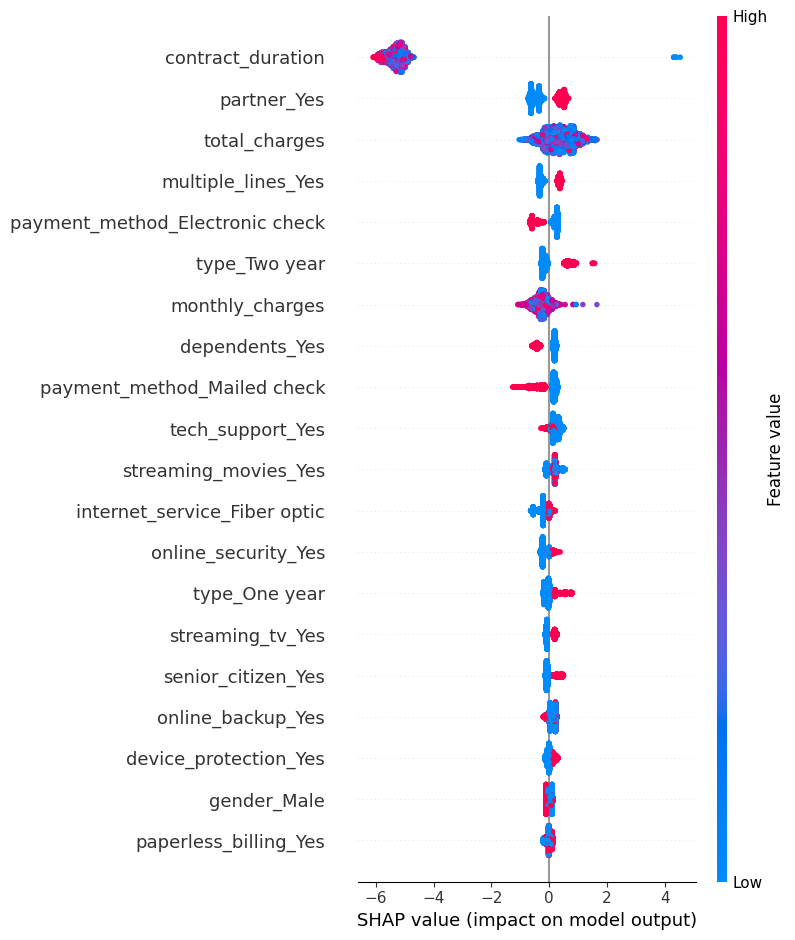

In [128]:
# Инициализация объекта Explainer для модели CatBoost
explainer = shap.TreeExplainer(grid_search_cat.best_estimator_['catboost'])

# Рассчитываем SHAP значения
shap_values = explainer.shap_values(X_train)

# Построение графика важности признаков
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

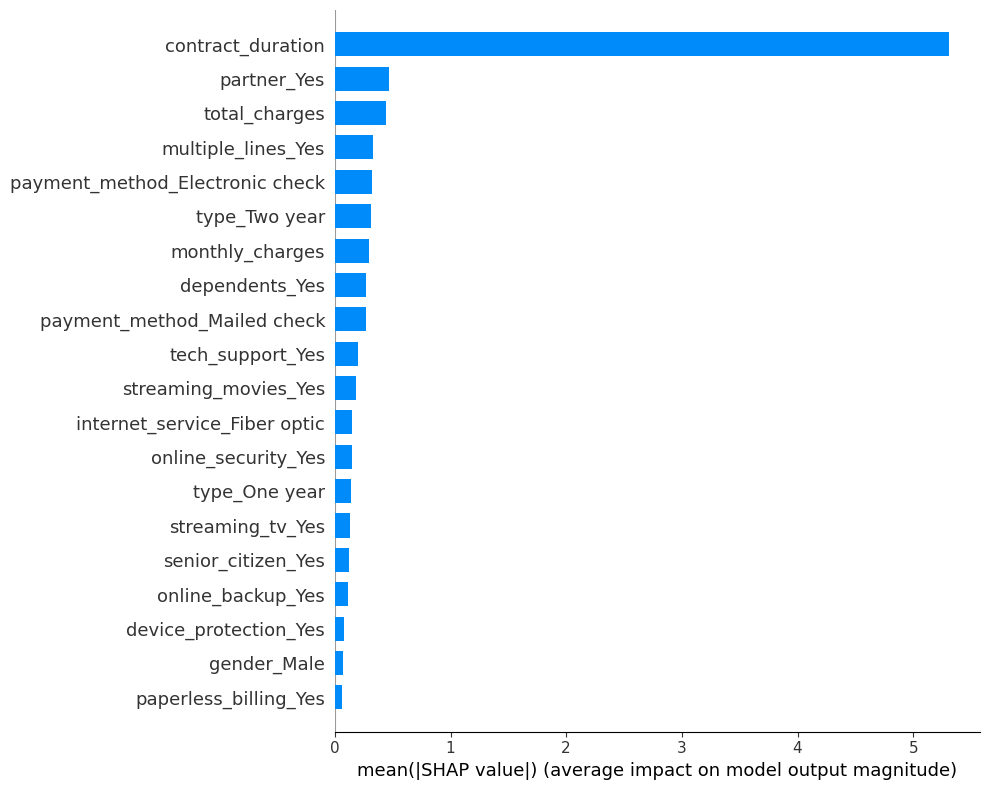

In [129]:
# Строим горизонтальный барплот с важностью признаков
shap.summary_plot(shap_values, X_train, plot_type="bar", plot_size=(10, 8))

### Вывод по шагу 7
- Свели результаты в таблицу для наглядности
- Лучшее значение на кросс-валидации показала модель CatBoostRegressor: ROC-AUC = 0.915
- Сделали предсказание на тестовой выборке, получили значение метрики ROC-AUC = 0.925
- Построили таблицу с важностью признаков, построили график с помощью shap

## Шаг 8. Общий вывод и рекомендации заказчику

### Общий вывод:
В ходе анализа данных и моделирования для предсказания оттока клиентов компании "ТелеДом" были выполнены следующие этапы:

#### Предварительная обработка данных:

- Проверены и обработаны пропуски в данных.
- Исправлены типы данных (например, преобразован столбец TotalCharges из типа object в числовой).
- Проведен первичный анализ, выявлены статистические особенности, такие как наличие аномалий или коллинеарности между признаками.
- Объединены таблицы для комплексного анализа.

#### Исследовательский анализ данных:

- Выявлены ключевые группы клиентов, наиболее склонных к оттоку (например, клиенты с несколькими телефонными линиями и более высокой месячной оплатой).
- Проанализированы данные по пенсионерам и клиентам с детьми.
- Заметны корреляции, например, между длительностью контракта и оттоком, а также между месячной оплатой и типом подключения.

#### Моделирование:

- Обучены несколько моделей, включая логистическую регрессию, дерево решений, случайный лес, KNN и бустинговые модели (XGBoost, LightGBM и CatBoost).
- Лучшая модель — CatBoost, показала высокое значение метрики ROC-AUC на тестовой выборке: 0.925.

#### Анализ важности признаков:

##### Основные признаки, влияющие на вероятность оттока клиентов, определены с помощью SHAP. Среди них:
- contract_duration — продолжительность договора;
- partner_Yes — наличие партнера у клиента;
- total_charges — общая сумма за оказанные услуги;
- multiple_lines_Yes — наличие нескольких телефонных линий;
- payment_method_Electronic check — способ оплаты (электронный чек);
- type_Two year — тип контракта (на два года);
- monthly_charges — ежемесячные платежи;
- dependents_Yes — наличие иждивенцев;
- payment_method_Mailed check — способ оплаты (почтовый чек).

##### Рекомендации:

###### Фокус на долгосрочных клиентах:
Клиенты с длительными контрактами (например, на два года) реже уходят, но высокая стоимость может стать критическим фактором. Рассмотрите возможность предоставления бонусов или скидок для таких клиентов, особенно при высокой месячной оплате.

###### Упрощение способов оплаты:
Клиенты, использующие электронные чеки, более склонны к оттоку. Внедрение удобных и автоматизированных способов оплаты (например, автоплатежи через банковские карты) может снизить отток.

###### Особое внимание на клиентов с несколькими телефонными линиями:
Абоненты с несколькими телефонными линиями также склонны разрывать договор. Возможно, стоит пересмотреть тарифы или предложить дополнительные преимущества для таких клиентов.

###### Персонализация предложений:
Разработка персонализированных предложений для клиентов с партнером и с детьми (семейные тарифы, дополнительные услуги) может помочь увеличить удержание этих групп клиентов.

###### Оптимизация стратегии для пенсионеров:
Пенсионеры составляют значительную часть клиентов, и хотя они не показывают высокой склонности к оттоку, для удержания можно предложить им специальные условия или скидки, чтобы повысить их лояльность.

###### Следующие шаги:
- Тестирование новых стратегий удержания: на основе данных, представленных выше, протестировать различные стратегии удержания для разных сегментов клиентов.
- Мониторинг и обновление моделей: постоянно обновлять модели и пересматривать важные признаки по мере накопления новых данных.
- Внедрение предложенных мер может способствовать снижению оттока клиентов, повышению их лояльности и увеличению прибыли компании.